<a href="https://colab.research.google.com/github/EricRibeiroAlves/Interacao-Humano-Robo/blob/main/%5BAP_T%5D_Eric_Modelo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Legenda**:
- $dt$: Passo de tempo (incremento de tempo entre as amostras).
- $t$: Tempo total (ou carimbo de tempo) da amostra.
- $R_d_T$: Derivada do torque do robô $\frac{d\tau_{r}}{dt}$ (variação do torque com o tempo).
- $\tau_{r}$: Torque do robô [R_T].
- $S_Fx$: Sensor de torque Tx [R_Fx].
- $\omega_{l}$: Velocidade da coroa [R_w_l].
- $\theta_{l}$: Ângulo da coroa [R_t_l].
- $\theta_{m}$: Ângulo do motor [R_t_m].
- $\omega_{h}$: Velocidade da pessoa [R_w_p].
- $\theta_{h}$: Ângulo da pessoa [R_t_p].
- $∫e(Interacao).dt$: Integral do erro de torque [R_i_T_e].
- $U(x)$: Sinal de controle [R_u].
- $\tau^{d}_{r}$: Torque desejado do robô [R_T_d].
- $\tau_{i}$: Torque de interação [R_T_i].
- $R_d_w_l$: Derivada da velocidade da coroa $\frac{d\omega_{l}}{dt}$ (variação da velocidade da coroa com o tempo).
- $phase$: Fase do movimento ou do ciclo (possivelmente relacionada à fase da marcha).
- $L_t_m$: Ângulo do motor na perna esquerda $\theta_{m, L}$.
- $L_t_l$: Ângulo da coroa na perna esquerda $\theta_{l, L}$.
- $L_u$: Sinal de controle aplicado ao lado esquerdo.
- $L_T_r$: Torque real no lado esquerdo $\tau_{r, L}$.
- $L_T_d$: Torque desejado no lado esquerdo $\tau^{d}_{r, L}$.



# 1º Passo: Bibliotecas

In [26]:
# Trato dos dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Libs p/ Modelo Deep LTSM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split



# 2º Passo: Importanto o dataset

In [27]:
drive.mount('/content/drive')

# Definir o caminho do arquivo
t1_markov = "drive/MyDrive/last_data_MarkovMao 1.dat"

# Definir os nomes das colunas
head_markov = ['dt', 't', 'R_d_T', 'R_T', 'R_Fx', 'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p',
               'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m', 'R_d_w_l', 'phase', 'L_t_m',
               'L_t_l', 'L_u', 'L_T_r', 'L_T_d']

# Configura o pandas para mostrar mais casas decimais
pd.set_option('display.float_format', lambda x: '%.10f' % x)

# Carregar o dataset com cabeçalhos definidos
markov_t1 = pd.read_table(t1_markov, header=None, names=head_markov, index_col=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3º Passo: Obtendo tau_i e d_tau_i

In [28]:
Ka = 200  # Rigidez do acessório
Ba = 10   # Amortecimento do acessório

# Cálculo do torque de interação τ_i
markov_t1['tau_i'] = Ka * (markov_t1['R_t_p'] - markov_t1['R_t_l']) + Ba * (markov_t1['R_w_p'] - markov_t1['R_w_l'])
markov_t1['d_tau_i'] = np.gradient(markov_t1['tau_i'])

# 4º Passo: Pré-processamento dos dados (Separação e Normalização)

In [29]:
dataset = markov_t1

# Pré-processamento
X = dataset[['tau_i', 'd_tau_i', 'phase','R_T']]
y = dataset[['R_T']]

# Normalização (MinMaxScaler)
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
# Convert the DataFrame to a NumPy array before reshaping
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)) # y.values extracts the underlying NumPy array


# 5º Passo: Definição dos parâmetros do modelo LTSM

In [30]:
# Parâmetros
timesteps = 10  # Número de timesteps a serem considerados
n_features = X_scaled.shape[1]  # Número de features (tau_i e d_tau_i)

# Criar sequências de dados para LSTM
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

# Gerar dados de treino
X_train, y_train = create_sequences(X_scaled, y_scaled, timesteps)

# Verificar forma dos dados
print("Forma dos dados de entrada para LSTM:", X_train.shape)  # Deve ser (samples, timesteps, n_features)
print("Forma dos dados de saída:", y_train.shape)  # Deve ser (samples, 1)

Forma dos dados de entrada para LSTM: (11989, 10, 4)
Forma dos dados de saída: (11989, 1)


# 6º Passo: Cria o modelo LTSM

In [31]:
# Definir o modelo LSTM aprimorado
model = Sequential()

# Primeira camada LSTM com Dropout
model.add(LSTM(100, return_sequences=True, input_shape=(timesteps, n_features)))  # Aumentado para 100 unidades
model.add(Dropout(0.3))  # Aumentado o Dropout para 30%

# Segunda camada LSTM com Dropout
model.add(LSTM(100, return_sequences=True))  # Outra camada com 100 unidades
model.add(Dropout(0.3))

# Terceira camada LSTM com Dropout
model.add(LSTM(50, return_sequences=False))  # Camada final com 50 unidades
model.add(Dropout(0.3))

# Camada densa (saída)
model.add(Dense(1))  # Saída de um único valor (tau_r)

# Compilar o modelo com Huber loss (mais robusto contra outliers)
model.compile(optimizer='adam', loss=Huber(), metrics=['MAE', 'MSE'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 7º Passo: Treina o modelo LTSM


In [33]:
# Treinar o modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.2)

# Fazer previsões
y_pred_scaled = model.predict(X_train)

# Reverter a normalização
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_train_rescaled = scaler_y.inverse_transform(y_train)

# Calcular o R² como métrica adicional
r2 = r2_score(y_train_rescaled, y_pred)
print(f'R²: {r2}')

# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(y_train_rescaled, y_pred)
print(f'MAE: {mae:.4f} Nm')

# Calcular o Erro Quadrático Médio da Raiz (RMSE)
rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_pred))
print(f'RMSE: {rmse:.4f} Nm')

# Exibir resultados aprimorados
for i in range(5):
    print(f"Real: {y_train_rescaled[i]}, Previsão: {y_pred[i]}")

Epoch 1/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - MAE: 0.0262 - MSE: 0.0012 - loss: 6.2015e-04 - val_MAE: 0.0177 - val_MSE: 5.3138e-04 - val_loss: 2.6569e-04
Epoch 2/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - MAE: 0.0236 - MSE: 0.0011 - loss: 5.2910e-04 - val_MAE: 0.0184 - val_MSE: 5.3995e-04 - val_loss: 2.6998e-04
Epoch 3/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - MAE: 0.0235 - MSE: 0.0011 - loss: 5.2523e-04 - val_MAE: 0.0141 - val_MSE: 3.4423e-04 - val_loss: 1.7212e-04
Epoch 4/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - MAE: 0.0219 - MSE: 9.2546e-04 - loss: 4.6273e-04 - val_MAE: 0.0162 - val_MSE: 4.1554e-04 - val_loss: 2.0777e-04
Epoch 5/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - MAE: 0.0215 - MSE: 8.9990e-04 - loss: 4.4995e-04 - val_MAE: 0.0204 - val_MSE: 6.1480e-04 - val_loss: 3.0740e-04
Epoch 6/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - MAE: 0.0217 - MSE: 9.2393e-04 - loss: 4.6197e-04 - val_MAE: 0.0136 - val_MSE: 3.2375e-04 - val_loss: 1.6187e-04
Epoc

# 8º Passo: Avaliação

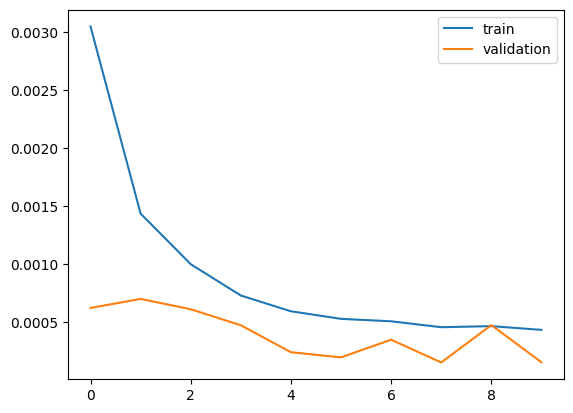

In [ ]:
# Visualizar a perda (train vs validation)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# 9º Passo: Gráfico comparativo entre os valores reais (y_test) e as previsões (y_pred)


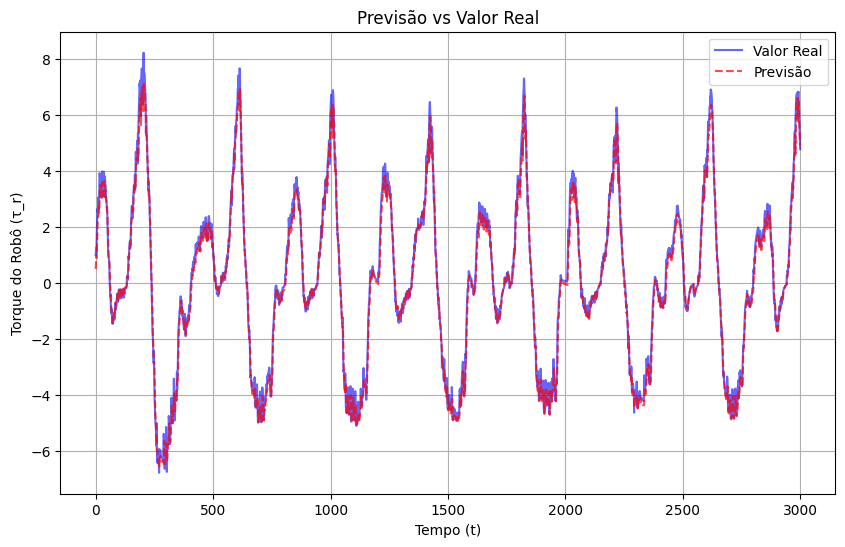

In [ ]:
# Função para plotar previsões vs valores reais
def plot_predictions(y_test_descaled, y_pred, title='Previsão vs Valor Real'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_descaled.flatten(), label='Valor Real', color='blue', alpha=0.6)
    plt.plot(y_pred.flatten(), label='Previsão', color='red', linestyle='--', alpha=0.7)
    plt.title(title)
    plt.xlabel('Tempo (t)')
    plt.ylabel('Torque do Robô (τ_r)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotando previsões vs valores reais (ajustado para uma parte específica do dataset)
plot_predictions(y_train_rescaled[4000:7000], y_pred[4000:7000])
